# Probablistic linear models using Pyro
August George, 2024, PNNL

## Linear regression

$y_i = m_i*x_i + b_i$

In [10]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import MCMC, NUTS

pyro.set_rng_seed(42)

In [11]:
# simulate the data
true_intercept = 1
true_slope = 2
num_data_points = 100  
X_values = torch.linspace(0, 1, num_data_points)
Y_values = true_intercept + true_slope * X_values 
Y_obs_values = Y_values + torch.randn(num_data_points) * 0.1 


In [15]:
def linear_model(X_values, Y_values):
    # priors
    intercept_prior = pyro.sample('intercept', dist.Normal(0, 10))
    slope_prior = pyro.sample('slope', dist.Normal(0, 10))
    noise_std_prior = pyro.sample('noise_std', dist.Uniform(0, 1))
    
    # linear model
    mean_prediction = intercept_prior + slope_prior * X_values
    
    # likelihood
    with pyro.plate('data', len(X_values)):
        pyro.sample('observations', dist.Normal(mean_prediction, noise_std_prior), obs=Y_values)


# MCMC inference
nuts_kernel = NUTS(linear_model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)
mcmc.run(X_values, Y_values)
posterior_samples = mcmc.get_samples()


Sample: 100%|██████████| 1200/1200 [00:04, 291.69it/s, step size=5.84e-04, acc. prob=0.084]


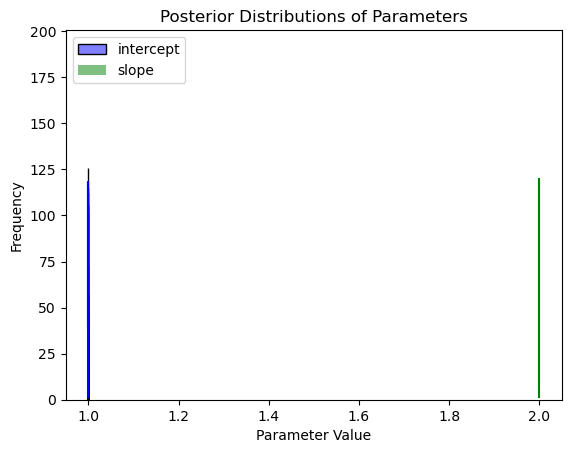

True intercept: 1 Estimated intercept mean: 0.9999997615814209 95% CI: [0.9999901652336121, 1.0000088214874268]
True slope: 2 Estimated slope mean: 1.999999761581421 95% CI: [1.9999836683273315, 2.000013828277588]
Estimated noise_std mean: 2.2196156351128593e-05 95% CI: [2.20882266148692e-05, 2.2297754185274243e-05]


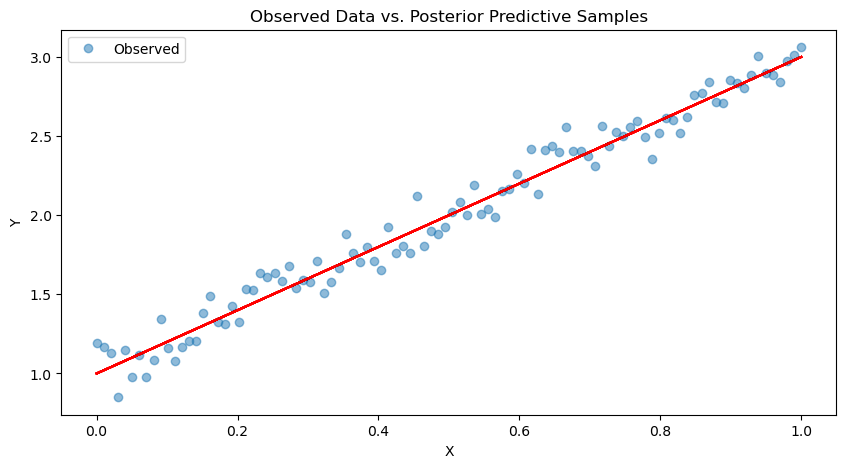

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt


intercept_samples = posterior_samples["intercept"].tolist()
slope_samples = posterior_samples["slope"].tolist()
noise_std_samples = posterior_samples["noise_std"].tolist()

sns.histplot(intercept_samples, kde=True, color='blue', label='intercept')
sns.histplot(slope_samples, kde=True, color='green', label='slope')
plt.legend()
plt.xlabel('Parameter Value')
plt.ylabel('Frequency')
plt.title('Posterior Distributions of Parameters')
plt.show()

intercept_mean = torch.mean(posterior_samples["intercept"]).item()
slope_mean = torch.mean(posterior_samples["slope"]).item()
noise_std_mean = torch.mean(posterior_samples["noise_std"]).item()

intercept_ci = torch.quantile(posterior_samples["intercept"], torch.tensor([0.025, 0.975])).tolist()
slope_ci = torch.quantile(posterior_samples["slope"], torch.tensor([0.025, 0.975])).tolist()
noise_std_ci = torch.quantile(posterior_samples["noise_std"], torch.tensor([0.025, 0.975])).tolist()

print("True intercept:", true_intercept, "Estimated intercept mean:", intercept_mean, "95% CI:", intercept_ci)
print("True slope:", true_slope, "Estimated slope mean:", slope_mean, "95% CI:", slope_ci)
print("Estimated noise_std mean:", noise_std_mean, "95% CI:", noise_std_ci)


def generate_posterior_predictive(samples, X_values):
    predictions = []
    for i in range(len(samples["intercept"])):
        intercept = samples["intercept"][i]
        slope = samples["slope"][i]
        noise_std = samples["noise_std"][i]
        predicted_y = intercept + slope * X_values + torch.randn(len(X_values)) * noise_std
        predictions.append(predicted_y)
    return torch.stack(predictions)


posterior_predictive_samples = generate_posterior_predictive(posterior_samples, X_values)

plt.figure(figsize=(10, 5))
plt.plot(X_values, Y_obs_values, 'o', label='Observed', alpha=0.5)
for i in range(100):
    plt.plot(X_values, posterior_predictive_samples[i], color='red', alpha=0.1)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Observed Data vs. Posterior Predictive Samples')
plt.show()